In [40]:
# INSTALL DEPENDENCIES (Colab only)
!pip install torch torchvision

# 🔧 IMPORTS
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import rasterio 
# 📦 CUSTOM DATASET
import rasterio

class VegetationDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        for label, subfolder in enumerate(['NO_VEGETATION', 'VEGETATION']):
            folder = os.path.join(root_dir, subfolder)
            for file in os.listdir(folder):
                if file.endswith(('.npy', '.tif', '.tiff')):
                    self.samples.append((os.path.join(folder, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        if path.endswith('.npy'):
            array = np.load(path)  # shape: [H, W, 15]
            red = array[:, :, 3] / 10000.0
            green = array[:, :, 2] / 10000.0
            blue = array[:, :, 1] / 10000.0
            ndvi = array[:, :, 13]
        elif path.endswith(('.tif', '.tiff')):
            with rasterio.open(path) as src:
                try:
                    red = src.read(4).astype(np.float32) / 10000.0
                    green = src.read(3).astype(np.float32) / 10000.0
                    blue = src.read(2).astype(np.float32) / 10000.0
                    nir = src.read(8).astype(np.float32) / 10000.0
                except IndexError:
                    raise ValueError(f"{os.path.basename(path)} doesn't contain required bands 2, 3, 4, and 8")
                ndvi = (nir - red) / (nir + red + 1e-5)
        else:
            raise ValueError(f"Unsupported file format: {path}")

        # Stack and resize
        stacked = np.stack([red, green, blue, ndvi], axis=0)  # [4, H, W]
        tensor = torch.tensor(stacked, dtype=torch.float32)
        tensor = F.interpolate(tensor.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False).squeeze(0)

        return tensor, torch.tensor(label, dtype=torch.float32)

#  MODEL
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # assuming 64x64 patches
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 16, 16]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

#  TRAINING SETUP
def train_model(dataset_path, num_epochs=10, batch_size=32):
    dataset = VegetationDataset(dataset_path)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = SimpleCNN(in_channels=4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

    return model

#  EVALUATION FUNCTION
def evaluate_model(model, val_loader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).squeeze() > 0.5
            correct += (outputs == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct / total:.2%}")

from PIL import Image

def predict(model, image_path):
    # Detect file type
    if image_path.endswith('.npy'):
        array = np.load(image_path)  # shape: [H, W, 15]
        red = array[:, :, 3] / 10000.0
        green = array[:, :, 2] / 10000.0
        blue = array[:, :, 1] / 10000.0
        ndvi = array[:, :, 13]

        # Stack to [4, H, W]
        stacked = np.stack([red, green, blue, ndvi], axis=0)
    elif image_path.endswith('.png') or image_path.endswith('.jpg'):
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64))  # Resize for consistency
        img = np.array(img).astype(np.float32) / 255.0

        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]
        ndvi = np.zeros_like(red)

        # Stack to [4, 64, 64]
        stacked = np.stack([red, green, blue, ndvi], axis=0)

    elif image_path.endswith('.tif') or image_path.endswith('.tiff'):
        import rasterio
        with rasterio.open(image_path) as src:
        # Read bands using Sentinel-2 standard band numbers:
        # Band 4 = red (index 4)
        # Band 3 = green (index 3)
        # Band 2 = blue (index 2)
        # Band 8 = NIR (index 8)
         red = src.read(4).astype(np.float32) / 10000.0
         green = src.read(3).astype(np.float32) / 10000.0
         blue = src.read(2).astype(np.float32) / 10000.0
         nir = src.read(8).astype(np.float32) / 10000.0

        # Compute NDVI
         ndvi = (nir - red) / (nir + red + 1e-5)

        # Stack to [4, H, W]
         stacked = np.stack([red, green, blue, ndvi], axis=0)
    else:
        raise ValueError("Unsupported file format. Use .npy or .png/.jpg")

    # Resize if needed (for .npy)
    if stacked.shape[1:] != (64, 64):
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)  # [1, 4, H, W]
        tensor = F.interpolate(tensor, size=(64, 64), mode='bilinear', align_corners=False)
    else:
        tensor = torch.tensor(stacked, dtype=torch.float32).unsqueeze(0)

    # Predict
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        prob = model(tensor.to(device)).item()
        label = "VEGETATION" if prob > 0.5 else "NO_VEGETATION"
   
   # visualize = true 
    import matplotlib.pyplot as plt

    rgb_vis = np.stack([red, green, blue], axis=-1)
    rgb_vis = np.clip(rgb_vis, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_vis)
    plt.title(f"Prediction: {label}", fontsize=14, color='green' if label == "VEGETATION" else 'red')
    plt.axis('off')
    plt.show()


    return label

In [37]:
import zipfile
import os

# Local path to the ZIP file
zip_path = r"C:\Users\mayer\Работен плот\final forest detector\sample_veg_detection_data"

# Folder where the data will be extracted
extracted_path = r"C:\Users\mayer\Работен плот\final forest detector\sample_veg_detection_data"

# Only extract if not already extracted
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Train the model using the extracted folder
model = train_model(extracted_path, num_epochs=25)

Epoch 1/25, Loss: 0.5194
Epoch 2/25, Loss: 0.2311
Epoch 3/25, Loss: 0.2777
Epoch 4/25, Loss: 0.2203
Epoch 5/25, Loss: 0.1630
Epoch 6/25, Loss: 0.1556
Epoch 7/25, Loss: 0.1484
Epoch 8/25, Loss: 0.1369
Epoch 9/25, Loss: 0.1001
Epoch 10/25, Loss: 0.0890
Epoch 11/25, Loss: 0.0652
Epoch 12/25, Loss: 0.0542
Epoch 13/25, Loss: 0.0439
Epoch 14/25, Loss: 0.0381
Epoch 15/25, Loss: 0.0305
Epoch 16/25, Loss: 0.0185
Epoch 17/25, Loss: 0.0166
Epoch 18/25, Loss: 0.0300
Epoch 19/25, Loss: 0.0488
Epoch 20/25, Loss: 0.0287
Epoch 21/25, Loss: 0.0156
Epoch 22/25, Loss: 0.0094
Epoch 23/25, Loss: 0.0100
Epoch 24/25, Loss: 0.0045
Epoch 25/25, Loss: 0.0036


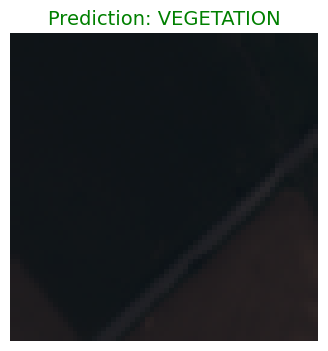

VEGETATION


In [41]:

import zipfile
import os


testFile_path = r"photos from DIego previous project/Highway_9.tif" # Get the uploaded filename
result = predict(model, testFile_path)
print(result)